In [1]:
# Load Datasets
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append("../classifier/")
from model.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from model.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from run.train import training
from run.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "../data/train_set"
rmsd_list = "../data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "../data/val_set"
val_rmsd = "../data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "../data/test_set"
test_rmsd = "../data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "../data/old_training_set"
st_test_rmsd = "../data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "../data/test_set_rot"
test_rmsd = "../data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "../data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?
    * use the module `JumpingKnowledge` in PyG

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [11]:
#model = MinCutCG(training_dataset.num_node_features)
model = DeepCG(training_dataset.num_node_features, [3, 8, 36, 3]) #[3, 4, 23, 3])

13.07.2022 15:42:20 Creating Training Directory at ../run_data/2022-07-13_15-42_DeepCG/
13.07.2022 15:42:20 Using CUDNN Benchmark
13.07.2022 15:42:20 Loading Datasets
13.07.2022 15:42:20 Start Training


Epoch 0: Training loss 16.8480; Validation loss 21.6683, MAE: 22.1293; lr: 0.00000
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 5: Training loss 16.1946; Validation loss 21.3216, MAE: 21.7959; lr: 0.00020
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 10: Training loss 11.9290; Validation loss 17.8748, MAE: 18.3717; lr: 0.00040
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 15: Training loss 3.7679; Validation loss 14.3458, MAE: 14.8389; lr: 0.00060
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 20: Training loss 2.8465; Validation loss 13.9279, MAE: 14.4221; lr: 0.00080
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 25: Training loss 2.3199; Validation loss 13.4056, MAE: 13.8952; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 30: Training loss 1.9902; Validation loss 13.7599, MAE: 14.2496; lr: 0.00080
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 35: Training loss 1.6694; Validation loss 13.7412, MAE: 14.2345; lr: 0.00060
	Add. 

13.07.2022 15:56:27 Training took 0.24 hours
13.07.2022 15:56:27 Minimum Training Loss 0.0847 in epoch 499
13.07.2022 15:56:27 Minimum Validation Loss (after 50 epochs) 13.2412 in epoch 404
13.07.2022 15:56:27 Minimum MAE (after 50 epochs) 13.7318 in epoch 404
13.07.2022 15:56:27 Seed used for training was: 10685708252937636299


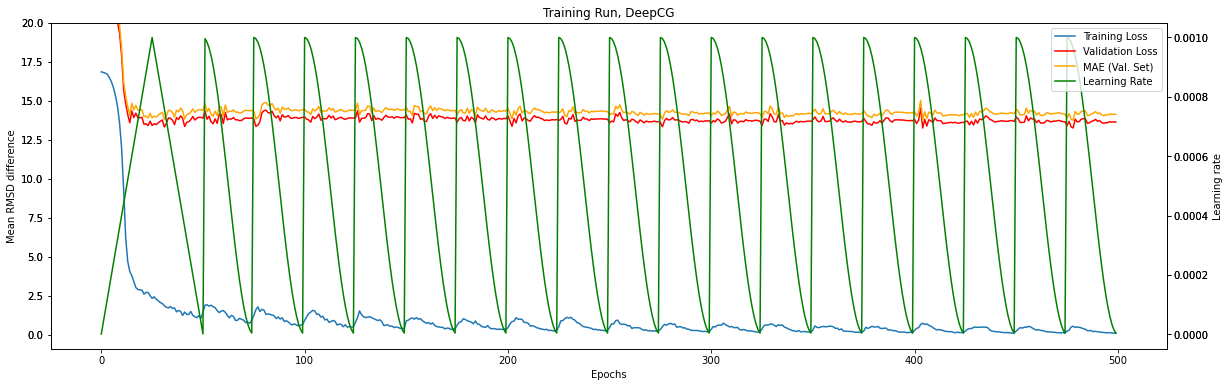

In [12]:
#Training
parent_dir = "../run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=500,
    sched_T0=25,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="../run_data/2022-07-04_10-2_MinCutCG/model_data/epoch_1999.pth",
    burn_in=50)

In [4]:
#get training run data

run_dir = "../run_data/2022-07-13_14-49_DeepCG"#"/scr/risa/mgeyer/GCN/run_data/2022-07-08_12-48_MinCutCG"#
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.0753 in epoch 499
Minimum Validation Loss (after 50 epochs) 12.9450 in epoch 51
Minimum MAE (after 50 epochs) 13.4257 in epoch 51


Validation Loss at 51 is 12.9450
5 before select
13.6201, 13.5173, 13.6692, 13.6801, 13.8379
5 after select
13.8399, 13.8973, 14.3247, 13.7924, 13.7765
MAE at 51 is 13.4257


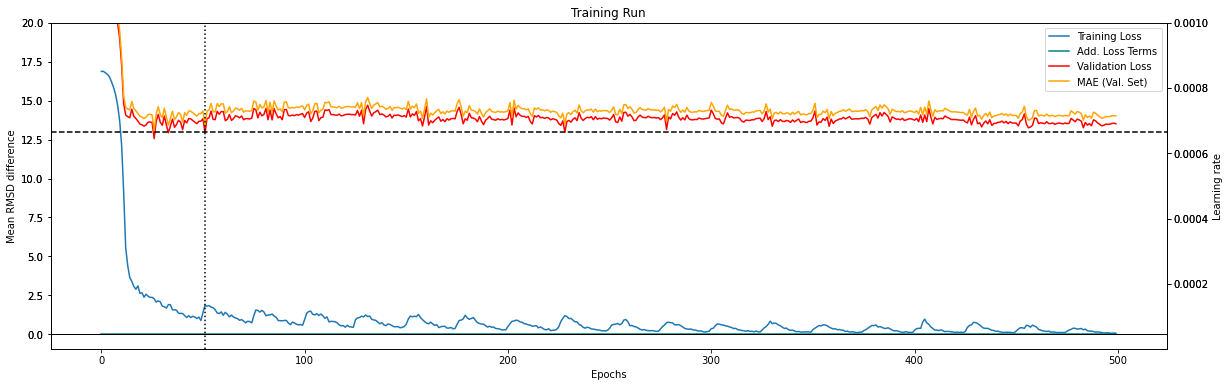

In [5]:
#plot the training run
select = 51

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(figsize=(20, 6))#layout="constrained", 
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0.0, linewidth=1, c = "black")#, ls = "--")
ax1.axhline(y=13, c = "black", ls = "--")

ax2.set_ylim([(min(learning_rates)), max(learning_rates)])

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 481
Test Set
Minimum Loss: Label = 19.3760, Prediction = 19.3902, Loss = 0.0001
Maximum Loss: Label = 42.3860, Prediction = 11.5848, Loss = 30.3012
Mean Test loss: 	 11.4647
Std. Dev. of Test loss:  7.2527
Min loss: 		 0.0001
First Quantile: 	 5.8336
Median: 		 11.1168
Third Quantile: 	 16.7409
Max Loss: 		 30.3012
LinregressResult(slope=-0.12228584680204906, intercept=18.889346816652814, rvalue=-0.05280463481581677, pvalue=0.38131220421247347, stderr=0.13945416227026358, intercept_stderr=2.484974947021122)


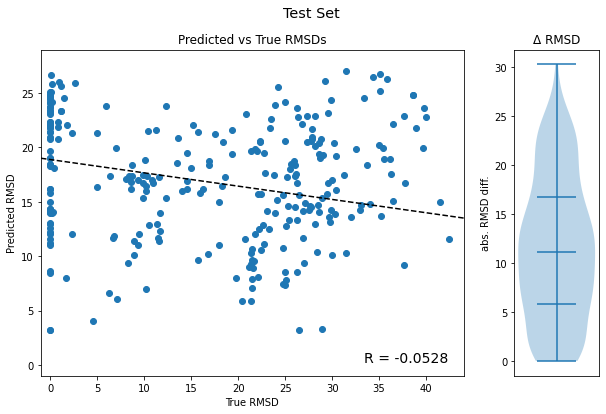

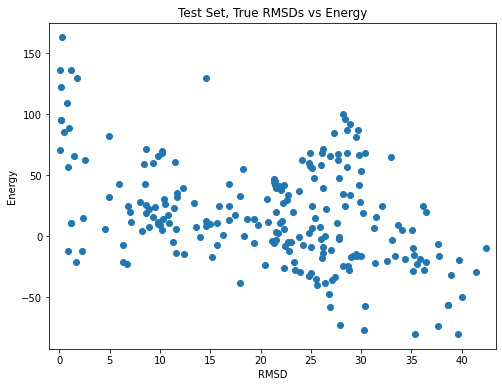

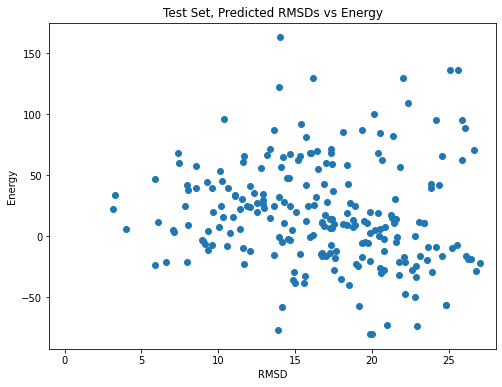

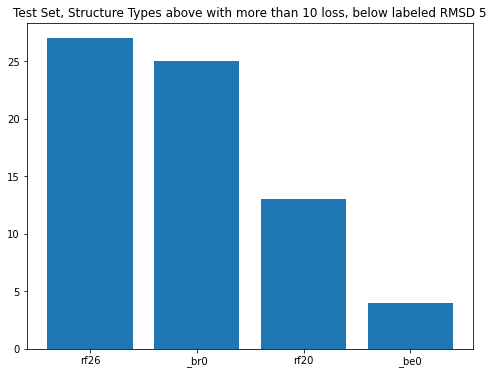

Prediction below 0: Label 0.1720, Pred -0.0094
Prediction below 0: Label 0.0000, Pred -0.2816
Prediction below 0: Label 0.0000, Pred -0.2267
Prediction below 0: Label 0.1340, Pred -0.2319
Prediction below 0: Label 0.1390, Pred -0.0706
Prediction below 0: Label 0.0000, Pred -0.2928
Prediction below 0: Label 0.0000, Pred -0.3128
Prediction below 0: Label 0.0920, Pred -0.1186
Prediction below 0: Label 0.0000, Pred -0.3552
Prediction below 0: Label 0.3800, Pred -0.0914
Prediction below 0: Label 0.0000, Pred -0.2784
Prediction below 0: Label 0.3260, Pred -0.1898
Prediction below 0: Label 0.0000, Pred -0.3181
5S and tRNA Test Set
Minimum Loss: Label = 27.5340, Prediction = 27.5292, Loss = 0.0000
Maximum Loss: Label = 0.1370, Prediction = 25.3051, Loss = 24.6681
Mean Test loss: 	 4.1848
Std. Dev. of Test loss:  4.6327
Min loss: 		 0.0000
First Quantile: 	 0.9215
Median: 		 2.6335
Third Quantile: 	 5.7174
Max Loss: 		 24.6681
LinregressResult(slope=0.8456504995087727, intercept=1.5329783561045

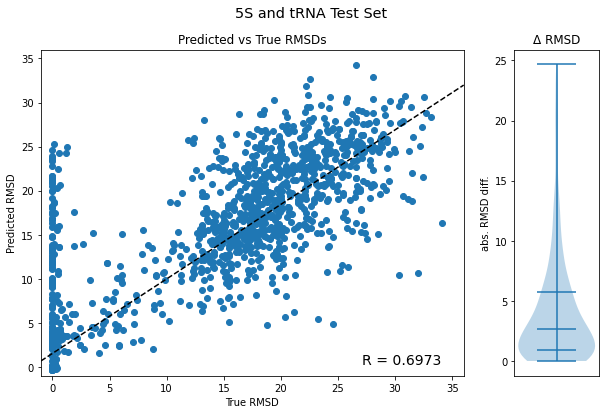

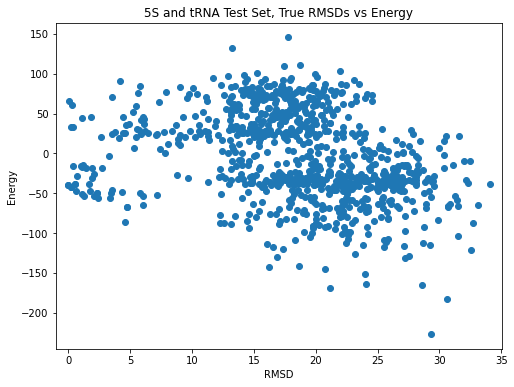

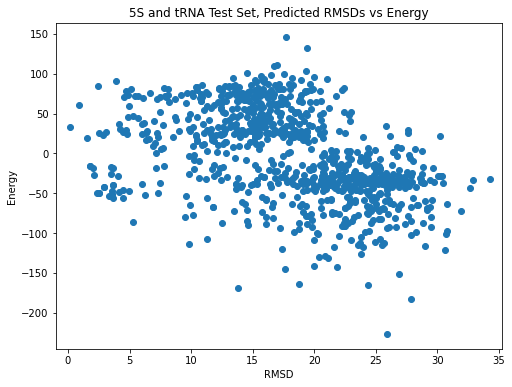

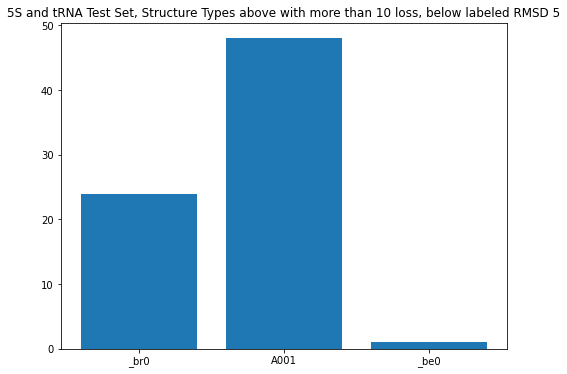

Prediction below 0: Label 0.0000, Pred -0.6605
Prediction below 0: Label 0.0900, Pred -0.2091
Prediction below 0: Label 0.0000, Pred -0.6605
Prediction below 0: Label 0.0000, Pred -0.6605
Prediction below 0: Label 0.1680, Pred -0.1061
Prediction below 0: Label 0.0900, Pred -0.2091
Prediction below 0: Label 0.0920, Pred -0.1186
Prediction below 0: Label 0.0920, Pred -0.1186
Prediction below 0: Label 0.0000, Pred -0.1203
Prediction below 0: Label 0.0000, Pred -0.1203
Prediction below 0: Label 0.0920, Pred -0.1186
Prediction below 0: Label 0.0000, Pred -0.1203
Prediction below 0: Label 0.1680, Pred -0.1061
Training Set
Minimum Loss: Label = 11.5170, Prediction = 11.5196, Loss = 0.0000
Maximum Loss: Label = 24.2730, Prediction = 28.6660, Loss = 3.8930
Mean Test loss: 	 0.2113
Std. Dev. of Test loss:  0.4042
Min loss: 		 0.0000
First Quantile: 	 0.0145
Median: 		 0.0767
Third Quantile: 	 0.2251
Max Loss: 		 3.8930
LinregressResult(slope=0.9721136902075534, intercept=0.344005080794215, rvalu

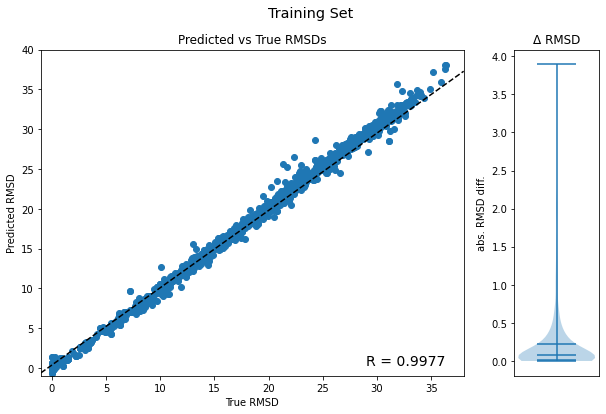

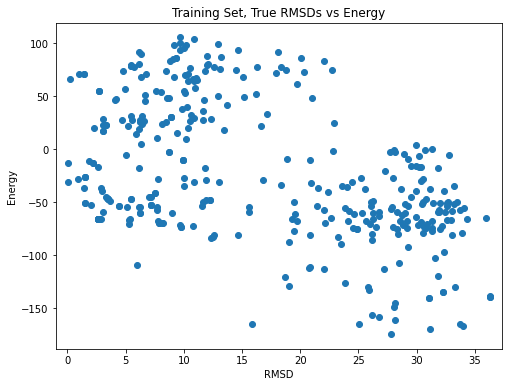

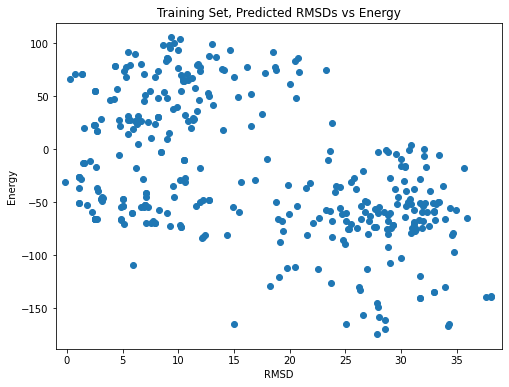

Validation Set
Minimum Loss: Label = 17.0460, Prediction = 17.0796, Loss = 0.0006
Maximum Loss: Label = 61.9850, Prediction = 5.8816, Loss = 55.6034
Mean Test loss: 	 13.8999
Std. Dev. of Test loss:  10.1457
Min loss: 		 0.0006
First Quantile: 	 5.6566
Median: 		 12.9045
Third Quantile: 	 20.2047
Max Loss: 		 55.6034
LinregressResult(slope=0.034322479661159803, intercept=22.5644863500765, rvalue=0.014249526637957534, pvalue=0.7774221734181729, stderr=0.12133497692413742, intercept_stderr=2.538657837715923)


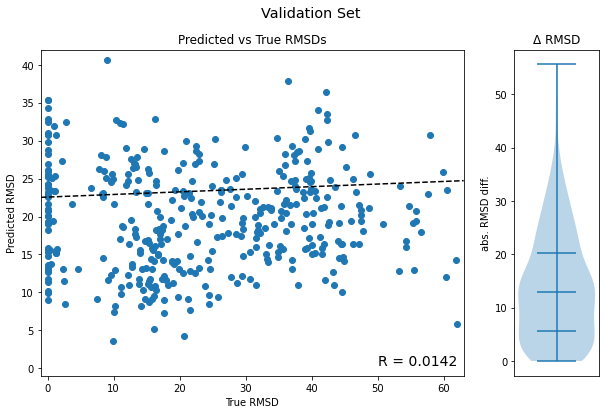

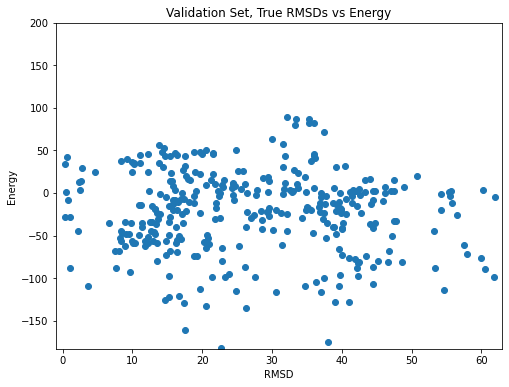

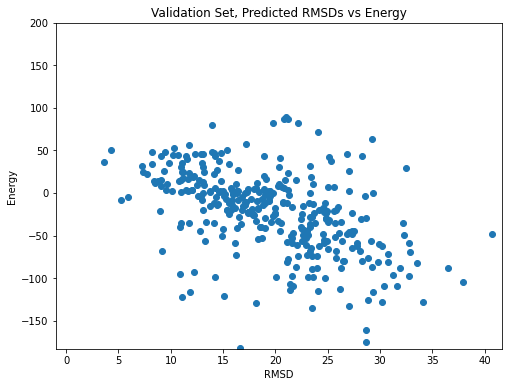

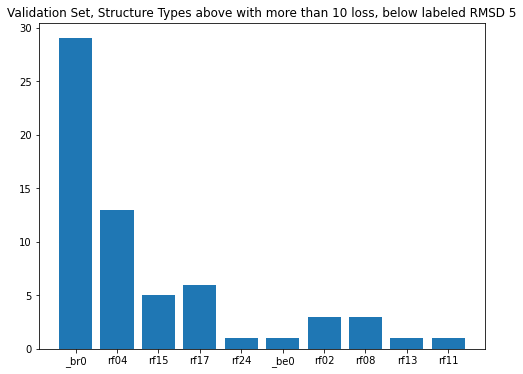

LinregressResult(slope=0.5467391589627483, intercept=10.80477883449169, rvalue=0.3500580129930038, pvalue=3.174960653941019e-44, stderr=0.0379145862050699, intercept_stderr=0.7365364129907247)


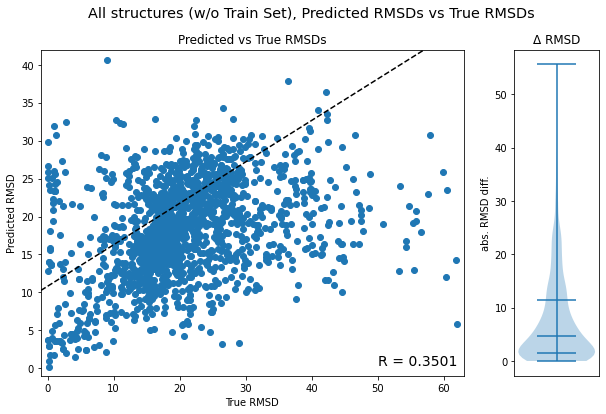

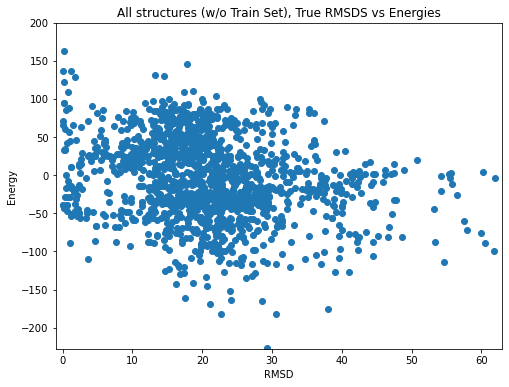

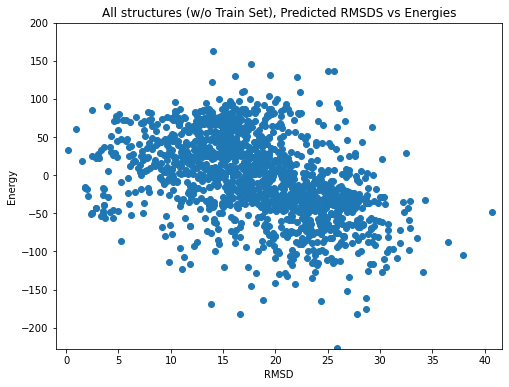

In [6]:
#Test
from run.utility import rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth", map_location=device)
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_list = "../data/test_energy.txt"
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_list = "../data/old_train_energy.txt"
    elif loader == train_loader:
        title = "Training Set"
        e_list = "../data/train_energy.txt"
    elif loader == val_loader:
        title = "Validation Set"
        e_list = "../data/val_energy.txt"
    en, trs, prs, tlosses = test(model, loader, title, device, e_list, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.8444808486943058, intercept=2.466309369267437, rvalue=0.8549240909876408, pvalue=2.3097994298691945e-80, stderr=0.030899867977820593, intercept_stderr=0.6044981453090565)


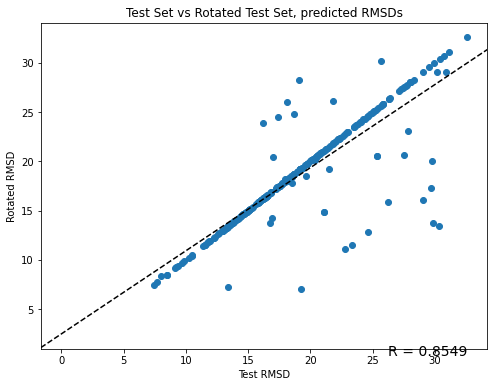

LinregressResult(slope=0.874592401793293, intercept=1.0439311875615633, rvalue=0.9290718318223314, pvalue=8.64099255122842e-121, stderr=0.020997792109900902, intercept_stderr=0.2986067111160438)


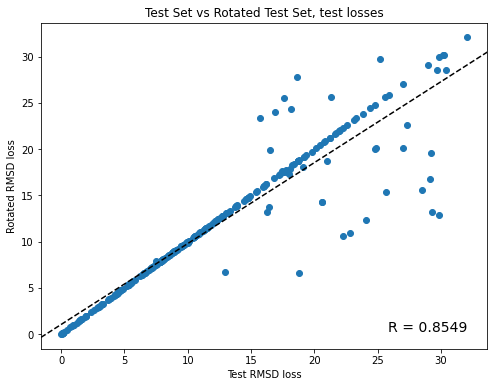

LinregressResult(slope=0.9587821986935745, intercept=0.736999149600976, rvalue=0.9619165941783716, pvalue=0.0, stderr=0.008286628299595523, intercept_stderr=0.15059816476149815)


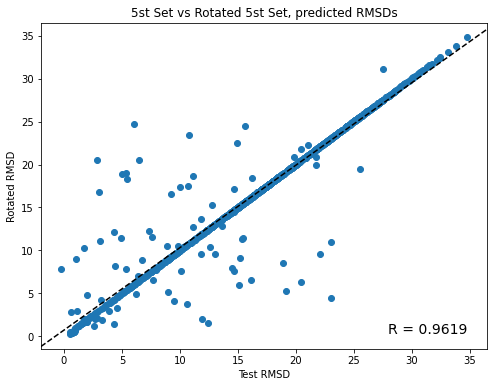

LinregressResult(slope=0.919581102331771, intercept=0.39323730815942515, rvalue=0.8998234324851364, pvalue=0.0, stderr=0.013559996757573106, intercept_stderr=0.08363657449607008)


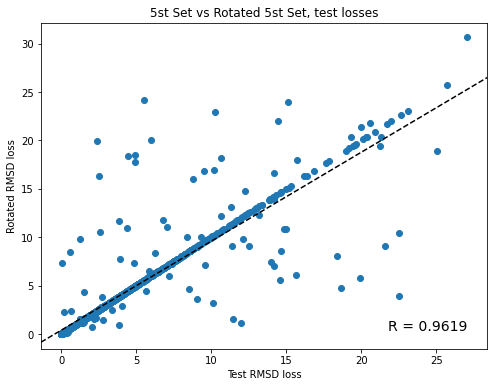

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots( figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")